<a href="https://colab.research.google.com/github/jahnvisikligar/Deep-Learning-Computer-Vision/blob/main/RESNET50_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 7s 0us/step


In [ ]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [ ]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


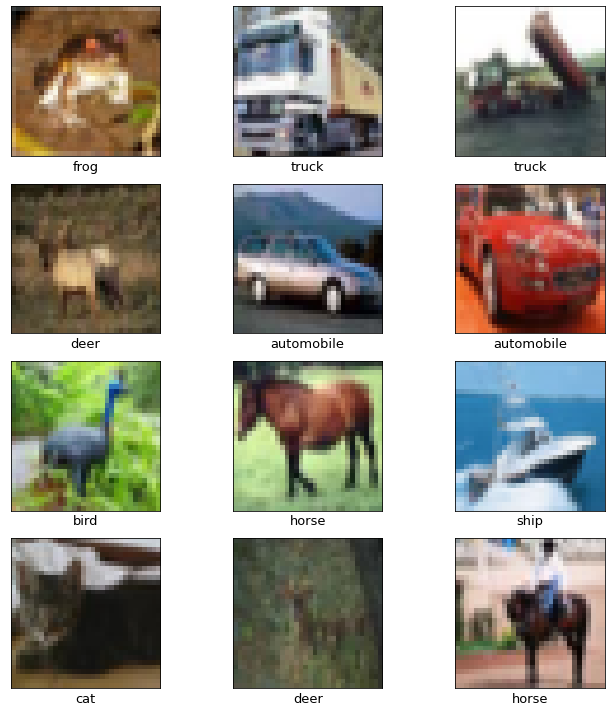

In [ ]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()    
plt.show()

In [ ]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(
    train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

In [ ]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [ ]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

In [ ]:
def res_identity(x, filters): 
  ''' renet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
resnet50_model = resnet50()

In [ ]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [ ]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
batch_size= 128  
# test with 64, 128, 256
"""
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=50, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])
"""
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=50, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv)

Epoch 1/50
312/312 [==============================] - 39s 69ms/step - loss: 17.5663 - acc: 0.2760 - val_loss: 15.2404 - val_acc: 0.1824
Epoch 2/50
312/312 [==============================] - 21s 67ms/step - loss: 12.7143 - acc: 0.3165 - val_loss: 34.3886 - val_acc: 0.1956
Epoch 3/50
312/312 [==============================] - 22s 69ms/step - loss: 9.3943 - acc: 0.3369 - val_loss: 8.1326 - val_acc: 0.3070
Epoch 4/50
312/312 [==============================] - 21s 66ms/step - loss: 7.4456 - acc: 0.3369 - val_loss: 12.4719 - val_acc: 0.1719
Epoch 5/50
312/312 [==============================] - 21s 66ms/step - loss: 6.2523 - acc: 0.3559 - val_loss: 6.4078 - val_acc: 0.3792
Epoch 6/50
312/312 [==============================] - 21s 67ms/step - loss: 5.6265 - acc: 0.3362 - val_loss: 120.5274 - val_acc: 0.1147
Epoch 7/50
312/312 [==============================] - 21s 66ms/step - loss: 4.8872 - acc: 0.3555 - val_loss: 4.8623 - val_acc: 0.3030
Epoch 8/50
312/312 [==============================] - 2

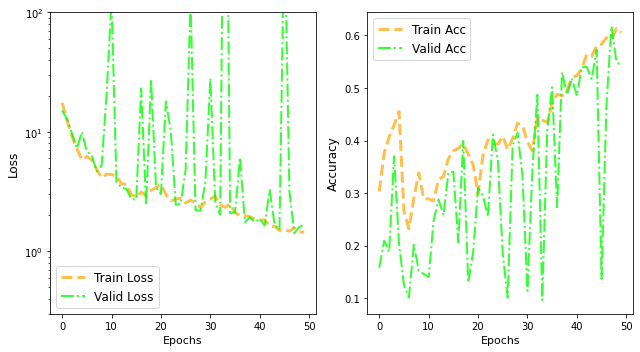

In [ ]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
  

Classification Report:

              precision    recall  f1-score   support

    airplane       0.22      0.84      0.35      1000
  automobile       0.69      0.60      0.64      1000
        bird       0.73      0.31      0.44      1000
         cat       0.67      0.02      0.04      1000
        deer       0.81      0.14      0.23      1000
         dog       0.00      0.00      0.00      1000
        frog       0.49      0.87      0.63      1000
       horse       0.55      0.76      0.64      1000
        ship       0.85      0.43      0.57      1000
       truck       0.74      0.74      0.74      1000

    accuracy                           0.47     10000
   macro avg       0.57      0.47      0.43     10000
weighted avg       0.57      0.47      0.43     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


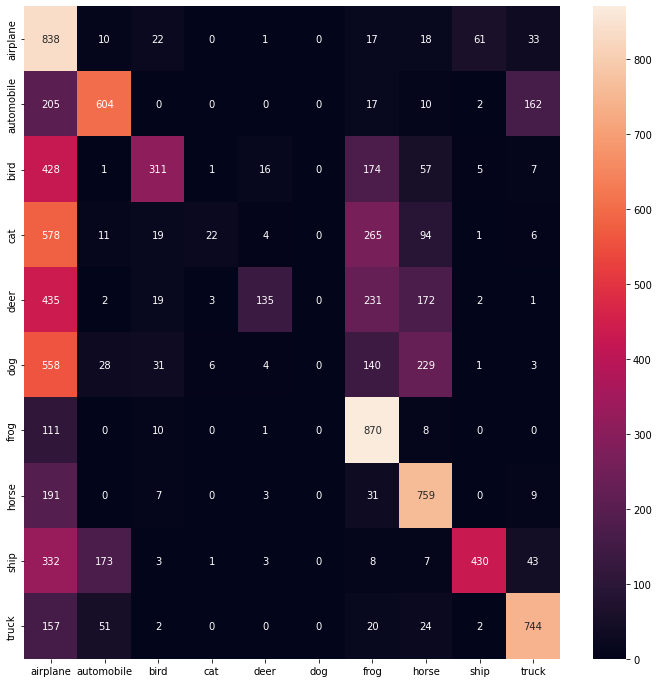

In [ ]:
pred_class_resnet50 = resnet50_model.predict(test_im)

conf_matrix(pred_class_resnet50)

In [ ]:
### Resutls on Test Data; 
## Check the performance on the test data 
test_result = resnet50_model.evaluate(test_im, test_lab_categorical, verbose=0)

print ("ResNet50 loss: ", test_result[0])
print ("ResNet50 accuracy: ", test_result[1])

ResNet50 loss:  1.7076926231384277
ResNet50 accuracy:  0.5392000079154968
